In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import time
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.metrics import r2_score
import warnings
warnings.filterwarnings('ignore')
from sklearn.datasets import fetch_california_housing
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV



In [4]:
class ASP(BaseEstimator, RegressorMixin):
    def __init__(self, alpha=1.0, rho=0.5, a=3.0, max_iter=100, tol=1e-4):
        self.alpha = alpha
        self.rho = rho
        self.a = a
        self.max_iter = max_iter
        self.tol = tol
        self.coef_ = None
        self.intercept_ = 0.0
    
    def _mcp_derivative(self, beta):
        lambda1 = self.alpha * self.rho
        deriv = np.zeros_like(beta)
        abs_beta = np.abs(beta)
        idx = abs_beta <= self.a * lambda1
        deriv[idx] = -lambda1 * np.sign(beta[idx]) * (1 - abs_beta[idx] / (self.a * lambda1))
        return deriv

    def fit(self, X, y):
        X_mean = np.mean(X, axis=0)
        y_mean = np.mean(y)
        X_centered = X - X_mean
        y_centered = y - y_mean
        
        n, p = X.shape
        beta = np.zeros(p)
        XtX_n = X_centered.T @ X_centered / n
        Xty_n = X_centered.T @ y_centered / n
        
        for _ in range(self.max_iter):
            beta_old = beta.copy()
            mcp_grad = self._mcp_derivative(beta)
            
            for j in range(p):
                if XtX_n[j, j] < 1e-10:
                    continue
                l_j = np.dot(XtX_n[j, :], beta) - XtX_n[j, j] * beta[j] - Xty_n[j] + mcp_grad[j]
                beta[j] = -np.sign(l_j) * max(0, abs(l_j) - self.alpha * (1 - self.rho)) / XtX_n[j, j]
            
            if np.linalg.norm(beta - beta_old) < self.tol:
                break
        
        self.coef_ = beta
        self.intercept_ = y_mean - np.dot(X_mean, beta)
        return self

    def predict(self, X):
        return X @ self.coef_ + self.intercept_

    def score(self, X, y):
        return r2_score(y, self.predict(X))


In [6]:

def simulate_data(n=100, p=100, s=5, snr=3, correlation=0.5, seed=None):
    if seed is not None:
        np.random.seed(seed)
    Sigma = np.zeros((p, p))
    for i in range(p):
        for j in range(p):
            Sigma[i, j] = correlation ** abs(i - j)
    X = np.random.multivariate_normal(mean=np.zeros(p), cov=Sigma, size=n)

    beta = np.zeros(p)
    

    if snr == 1:
        c = 0.599  # From the paper for SNR = 1
    elif snr == 3:
        c = 1.798  # From the paper for SNR = 3
    else:
        sigma = 2  # Error standard deviation in the paper
        # Using SNR = sqrt(beta'Σbeta / sigma^2)
        c = np.sqrt(snr * sigma**2 / (s * (1 + 2 * correlation / (1 - correlation))))
    
    beta[:s] = c
    
    # Generate y
    sigma = 2  # Fixed in the paper
    epsilon = np.random.normal(0, sigma, n)
    y = X @ beta + epsilon
    
    return X, y, beta

In [7]:

def evaluate_model(model, X_train, y_train, X_test, y_test, beta_true):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    pe = mean_squared_error(y_test, y_pred)
    
    num_selected = np.sum(np.abs(model.coef_) > 1e-8)
    
    sig = np.sum(np.abs(model.coef_[:np.sum(beta_true != 0)]) > 1e-8)
    
    noi = num_selected - sig
    
    return {
        'PE': pe,
        'SIG': sig,
        'NOI': noi,
        'NUM': num_selected
    }


In [8]:
def run_simulation(n=100, p=100, snr=1, n_reps=20):
    """Run a simulation study comparing LASSO, MCP, and ASP"""
    results = {
        'LASSO': {'PE': [], 'SIG': [], 'NOI': [], 'NUM': []},
        'MCP_0.9': {'PE': [], 'SIG': [], 'NOI': [], 'NUM': []},
        'ASP_0.1': {'PE': [], 'SIG': [], 'NOI': [], 'NUM': []},
        'ASP_0.3': {'PE': [], 'SIG': [], 'NOI': [], 'NUM': []},
        'ASP_0.5': {'PE': [], 'SIG': [], 'NOI': [], 'NUM': []},
        'ASP_0.7': {'PE': [], 'SIG': [], 'NOI': [], 'NUM': []},
        'ASP_0.9': {'PE': [], 'SIG': [], 'NOI': [], 'NUM': []}
    }
    
    for rep in range(n_reps):
        print(f"Replication {rep+1}/{n_reps}")
        
        X, y, beta_true = simulate_data(n=n, p=p, s=5, snr=snr, seed=rep)
        
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=rep)
        
        alpha = 0.1  
        
        # Test LASSO
        lasso = Lasso(alpha=alpha, max_iter=10000)
        lasso_results = evaluate_model(lasso, X_train, y_train, X_test, y_test, beta_true)
        for key in lasso_results:
            results['LASSO'][key].append(lasso_results[key])
        
        # Test MCP (approximated as ASP with rho=0.9)
        mcp = ASP(alpha=alpha, rho=0.9, a=3.0)
        mcp_results = evaluate_model(mcp, X_train, y_train, X_test, y_test, beta_true)
        for key in mcp_results:
            results['MCP_0.9'][key].append(mcp_results[key])
        
        # Test ASP with different rho values
        for rho in [0.1, 0.3, 0.5, 0.7, 0.9]:
            asp = ASP(alpha=alpha, rho=rho, a=3.0)
            asp_results = evaluate_model(asp, X_train, y_train, X_test, y_test, beta_true)
            for key in asp_results:
                results[f'ASP_{rho}'][key].append(asp_results[key])
    
    # Calculate means
    for method in results:
        for metric in results[method]:
            results[method][metric] = np.mean(results[method][metric])
    
    return results

In [9]:

# Run the SNR = 1 simulation
print("Running simulation with SNR = 1")
results_snr1 = run_simulation(n=100, p=100, snr=1, n_reps=20)

# Print the results for SNR = 1
print("\nResults for SNR = 1:")
print("Method\tPE\tSIG\tNOI\tNUM")
for method, metrics in results_snr1.items():
    print(f"{method}\t{metrics['PE']:.4f}\t{metrics['SIG']:.1f}\t{metrics['NOI']:.1f}\t{metrics['NUM']:.1f}")

# Run the SNR = 3 simulation
print("\nRunning simulation with SNR = 3")
results_snr3 = run_simulation(n=100, p=100, snr=3, n_reps=20)

# Print the results for SNR = 3
print("\nResults for SNR = 3:")
print("Method\tPE\tSIG\tNOI\tNUM")
for method, metrics in results_snr3.items():
    print(f"{method}\t{metrics['PE']:.4f}\t{metrics['SIG']:.1f}\t{metrics['NOI']:.1f}\t{metrics['NUM']:.1f}")

def plot_penalty_functions(alpha=1.0, a=3.0):
    """Plot the penalty functions for different values of rho"""
    beta = np.linspace(-4, 4, 1000)
    
    # LASSO penalty
    lasso_penalty = alpha * np.abs(beta)
    
    # MCP penalty
    mcp_penalty = np.zeros_like(beta)
    idx = np.abs(beta) <= a * alpha
    mcp_penalty[idx] = alpha * np.abs(beta[idx]) - np.abs(beta[idx])**2 / (2 * a)
    mcp_penalty[~idx] = 0.5 * a * alpha**2
    
    # ASP penalties for different rho values
    rho_values = [0.1, 0.5, 0.9]
    asp_penalties = {}
    
    for rho in rho_values:
        asp_penalty = np.zeros_like(beta)
        lambda1 = alpha * rho
        lambda2 = alpha * (1 - rho)
        
        # MCP component
        idx = np.abs(beta) <= a * lambda1
        asp_penalty[idx] += lambda1 * np.abs(beta[idx]) - np.abs(beta[idx])**2 / (2 * a)
        asp_penalty[~idx] += 0.5 * a * lambda1**2
        
        # LASSO component
        asp_penalty += lambda2 * np.abs(beta)
        
        asp_penalties[rho] = asp_penalty
    
    # Create the plot
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    
    for i, rho in enumerate(rho_values):
        axes[i].plot(beta, lasso_penalty, 'r--', label='LASSO')
        axes[i].plot(beta, mcp_penalty, 'b--', label='MCP')
        axes[i].plot(beta, asp_penalties[rho], 'g-', label=f'ASP (ρ = {rho})')
        axes[i].set_title(f'ρ = {rho}')
        axes[i].set_xlabel('β')
        axes[i].set_ylabel('J(β)')
        axes[i].legend()
        axes[i].grid(True)
    
    plt.tight_layout()
    plt.show()

Running simulation with SNR = 1
Replication 1/20
Replication 2/20
Replication 3/20
Replication 4/20
Replication 5/20
Replication 6/20
Replication 7/20
Replication 8/20
Replication 9/20
Replication 10/20
Replication 11/20
Replication 12/20
Replication 13/20
Replication 14/20
Replication 15/20
Replication 16/20
Replication 17/20
Replication 18/20
Replication 19/20
Replication 20/20

Results for SNR = 1:
Method	PE	SIG	NOI	NUM
LASSO	6.0474	4.5	33.5	38.0
MCP_0.9	12.6411	5.0	95.0	100.0
ASP_0.1	6.2557	4.6	38.8	43.4
ASP_0.3	6.7216	4.8	53.5	58.3
ASP_0.5	7.2650	5.0	72.2	77.2
ASP_0.7	8.1252	5.0	93.1	98.1
ASP_0.9	12.6411	5.0	95.0	100.0

Running simulation with SNR = 3
Replication 1/20
Replication 2/20
Replication 3/20
Replication 4/20
Replication 5/20
Replication 6/20
Replication 7/20
Replication 8/20
Replication 9/20
Replication 10/20
Replication 11/20
Replication 12/20
Replication 13/20
Replication 14/20
Replication 15/20
Replication 16/20
Replication 17/20
Replication 18/20
Replication 19/20
Re

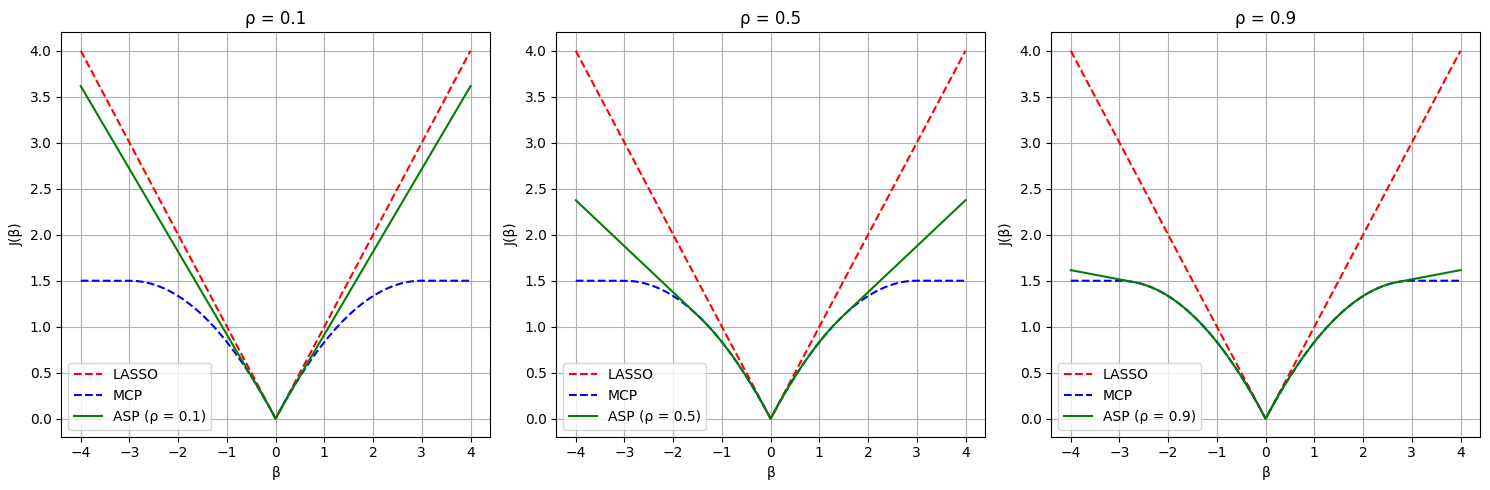

In [10]:
plot_penalty_functions()

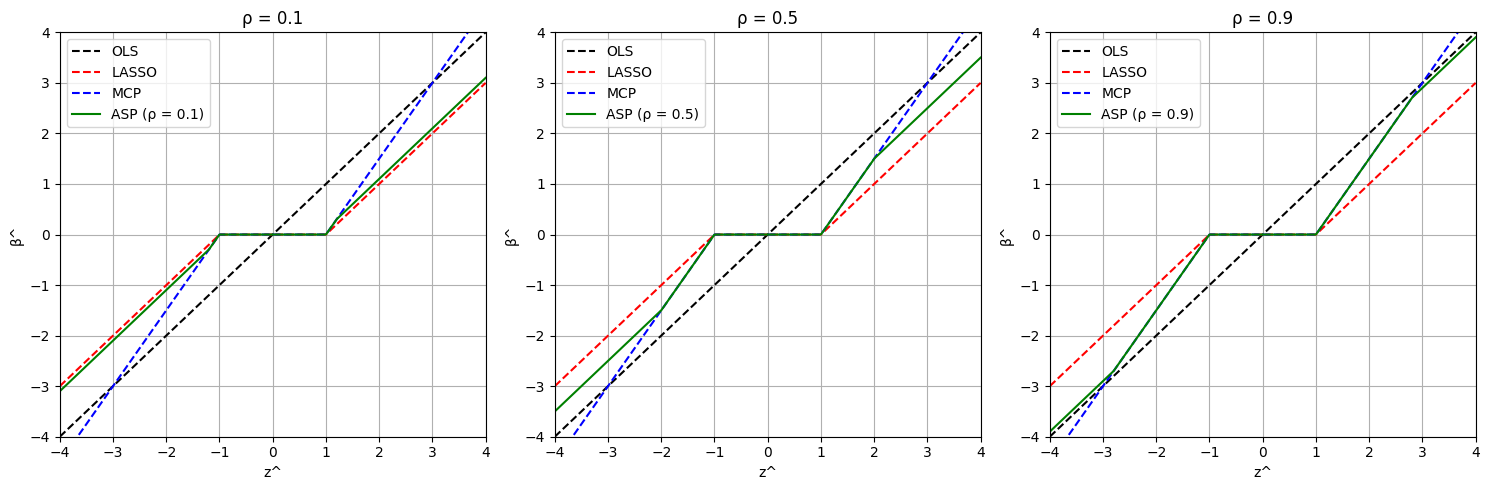

In [11]:

def plot_solution_paths():
    z = np.linspace(-4, 4, 1000)
    
    # LASSO solution
    lasso_solution = np.sign(z) * np.maximum(0, np.abs(z) - 1)
    
    # MCP solution (a=3)
    mcp_solution = np.zeros_like(z)
    idx1 = np.abs(z) <= 1
    idx2 = (np.abs(z) > 1) & (np.abs(z) <= 4)  # a*lambda = 3*1 = 3
    idx3 = np.abs(z) > 4
    
    mcp_solution[idx1] = 0
    mcp_solution[idx2] = np.sign(z[idx2]) * (np.abs(z[idx2]) - 1) * 3/2
    mcp_solution[idx3] = z[idx3]
    
    # ASP solutions for different rho values
    rho_values = [0.1, 0.5, 0.9]
    asp_solutions = {}
    
    for rho in rho_values:
        asp_sol = np.zeros_like(z)
        lambda1 = rho
        lambda2 = 1 - rho
        threshold = lambda1 + lambda2  # = 1
        
        idx1 = np.abs(z) <= threshold
        idx2 = (np.abs(z) > threshold) & (np.abs(z) <= 3*lambda1 + lambda2)
        idx3 = np.abs(z) > 3*lambda1 + lambda2
        
        asp_sol[idx1] = 0
        asp_sol[idx2] = np.sign(z[idx2]) * (np.abs(z[idx2]) - threshold) * 3/2
        asp_sol[idx3] = np.sign(z[idx3]) * (np.abs(z[idx3]) - lambda2)
        
        asp_solutions[rho] = asp_sol
    
    # Create the plot
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    
    for i, rho in enumerate(rho_values):
        axes[i].plot(z, z, 'k--', label='OLS')
        axes[i].plot(z, lasso_solution, 'r--', label='LASSO')
        axes[i].plot(z, mcp_solution, 'b--', label='MCP')
        axes[i].plot(z, asp_solutions[rho], 'g-', label=f'ASP (ρ = {rho})')
        axes[i].set_title(f'ρ = {rho}')
        axes[i].set_xlabel('z^')
        axes[i].set_ylabel('β^')
        axes[i].grid(True)
        axes[i].legend()
        axes[i].set_xlim(-4, 4)
        axes[i].set_ylim(-4, 4)
    
    plt.tight_layout()
    plt.show()

# Plot the solution paths
plot_solution_paths()

In [12]:
california_housing = fetch_california_housing()
data = pd.DataFrame(california_housing.data, columns=california_housing.feature_names)

data['target'] = california_housing.target

describ1=data.describe()
print(describ1)

             MedInc      HouseAge      AveRooms     AveBedrms    Population  \
count  20640.000000  20640.000000  20640.000000  20640.000000  20640.000000   
mean       3.870671     28.639486      5.429000      1.096675   1425.476744   
std        1.899822     12.585558      2.474173      0.473911   1132.462122   
min        0.499900      1.000000      0.846154      0.333333      3.000000   
25%        2.563400     18.000000      4.440716      1.006079    787.000000   
50%        3.534800     29.000000      5.229129      1.048780   1166.000000   
75%        4.743250     37.000000      6.052381      1.099526   1725.000000   
max       15.000100     52.000000    141.909091     34.066667  35682.000000   

           AveOccup      Latitude     Longitude        target  
count  20640.000000  20640.000000  20640.000000  20640.000000  
mean       3.070655     35.631861   -119.569704      2.068558  
std       10.386050      2.135952      2.003532      1.153956  
min        0.692308     32.54000

In [11]:
data.shape

(20640, 9)

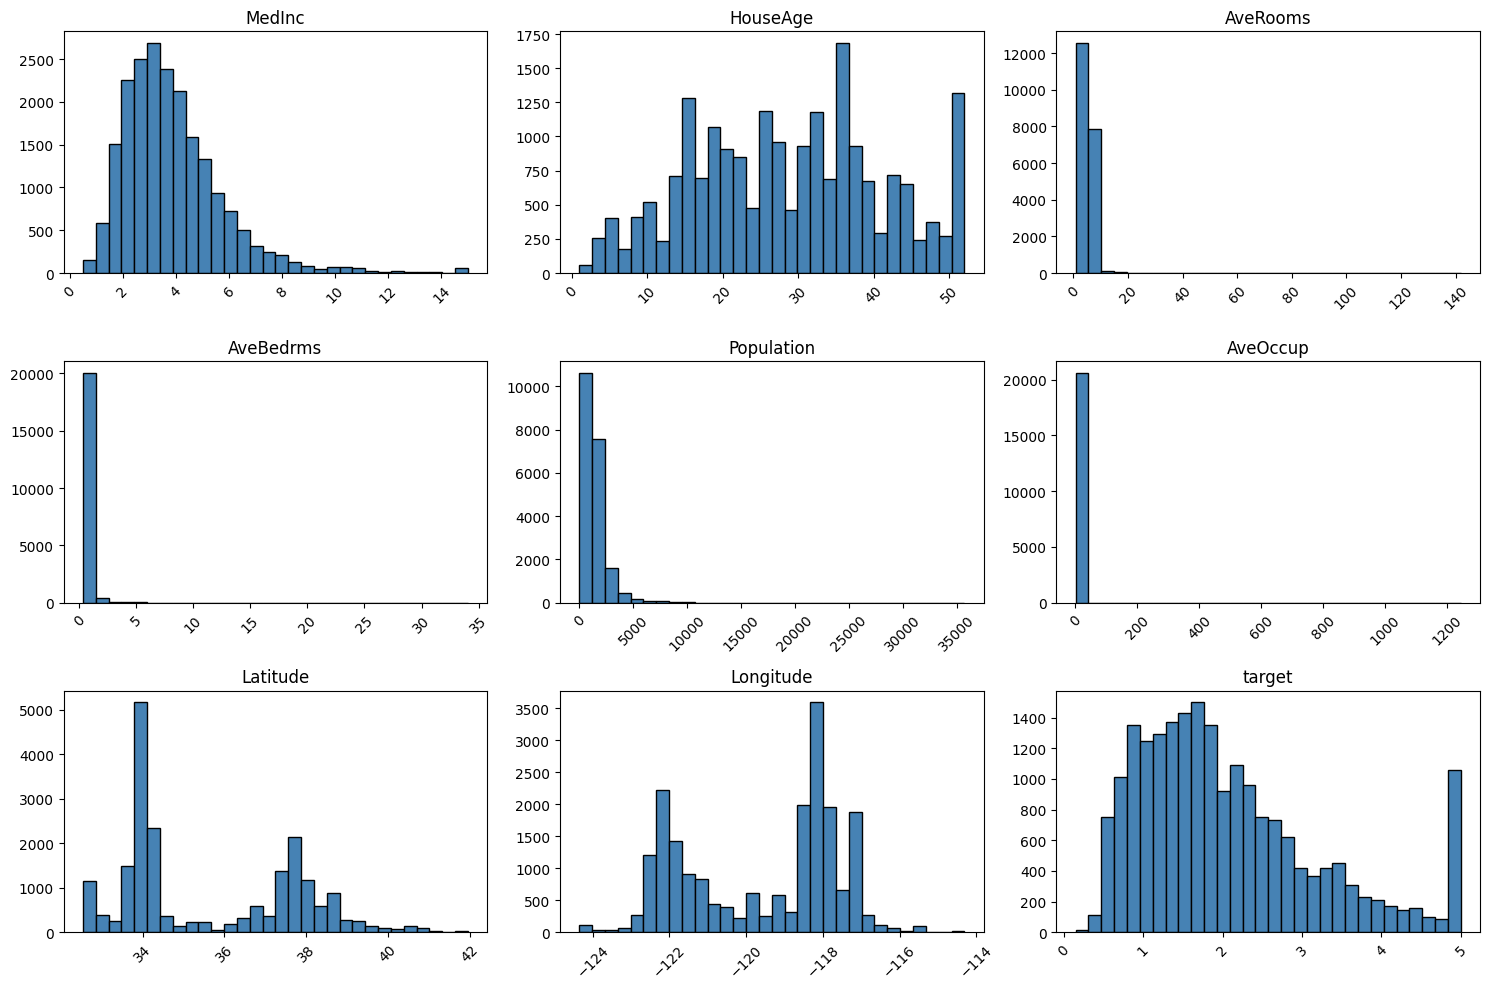

In [13]:
df=data
numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
num_cols = 3
num_rows = (len(numeric_cols) + num_cols - 1) // num_cols  # Ceiling division

fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 10))
axes = axes.flatten()

for i, col in enumerate(numeric_cols):
    unique_vals = df[col].dropna().unique()
    
    if set(unique_vals).issubset({0, 1}):
        counts = df[col].value_counts().sort_index()
        axes[i].bar(counts.index.astype(str), counts.values, color='skyblue', edgecolor='black')
        axes[i].set_xticks([0, 1])
        axes[i].set_xticklabels(['0', '1'])
    else:
        axes[i].hist(df[col], bins=30, color='steelblue', edgecolor='black')

    axes[i].set_title(col)
    axes[i].tick_params(axis='x', rotation=45)

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

In [14]:
california = fetch_california_housing()
X, y = california.data, california.target
feature_names = california.feature_names

In [15]:
print(feature_names)

['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup', 'Latitude', 'Longitude']


In [16]:
def RealDataModelling():
    # Load and prepare data
    # california = fetch_california_housing()
    # X, y = california.data, california.target
    # feature_names = california.feature_names
    # feature_names =  dataset.columns
    # X = dataset.drop('Price', axis=1)
    # y = dataset['Price']
    # # Train-test split and scaling
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Define models to compare
    models = {
        'LASSO': Lasso(),
        'MCP (ρ=0.9)': ASP(rho=0.9),  # MCP approximation
        'ASP (ρ=0.1)': ASP(rho=0.1),
        'ASP (ρ=0.3)': ASP(rho=0.3),
        'ASP (ρ=0.5)': ASP(rho=0.5),
        'ASP (ρ=0.7)': ASP(rho=0.7),
        'ASP (ρ=0.9)': ASP(rho=0.9)
    }

    # Parameter grids for tuning
    param_grids = {
        'LASSO': {'alpha': np.logspace(-3, 1, 20)},
        'MCP (ρ=0.9)': {'alpha': np.logspace(-3, 1, 20), 'a': [2.5, 3.0, 3.5]},
        'ASP (ρ=0.1)': {'alpha': np.logspace(-3, 1, 20), 'a': [2.5, 3.0, 3.5]},
        'ASP (ρ=0.3)': {'alpha': np.logspace(-3, 1, 20), 'a': [2.5, 3.0, 3.5]},
        'ASP (ρ=0.5)': {'alpha': np.logspace(-3, 1, 20), 'a': [2.5, 3.0, 3.5]},
        'ASP (ρ=0.7)': {'alpha': np.logspace(-3, 1, 20), 'a': [2.5, 3.0, 3.5]},
        'ASP (ρ=0.9)': {'alpha': np.logspace(-3, 1, 20), 'a': [2.5, 3.0, 3.5]}
    }

    # Results storage
    results = []

    # Train and evaluate each model
    for name in models:
        print(f"\nTraining {name}...")
        start_time = time.time()
        gs = GridSearchCV(models[name], param_grids[name], cv=5, scoring='neg_mean_squared_error')
        gs.fit(X_train_scaled, y_train)
        
        end_time = time.time()
        training_time = end_time - start_time
        best = gs.best_estimator_
        y_pred = best.predict(X_test_scaled)
        
        results.append({
            'Model': name,
            'Best Params': gs.best_params_,
            'MSE': mean_squared_error(y_test, y_pred),
            'R2': r2_score(y_test, y_pred),
            'Features Selected': np.sum(np.abs(best.coef_) > 1e-8),
            'Coefficients': best.coef_,
            'Training': training_time
        })

    # Display results
    print("\nModel Comparison Results:")
    print("{:<12} {:<25} {:<10} {:<10} {:<15} {:<45}".format(
        'Model', 'Best Parameters', 'MSE', 'R2', 'Features', 'TrainingTime(sec)'))
    
    for res in results:
        params_str = ', '.join([f"{k}={v:.3f}" for k, v in res['Best Params'].items()])
        print("{:<12} {:<25} {:<10.4f} {:<10.4f} {:<15}{:<45}".format(
            res['Model'], params_str, res['MSE'], res['R2'], res['Features Selected'], res['Training']))

    # Plot coefficients
    plt.figure(figsize=(15, 8))
    for i, res in enumerate(results, 1):
        plt.subplot(2, 4, i)
        plt.stem(res['Coefficients'], linefmt='-', markerfmt='o', basefmt=' ')
        plt.title(f"{res['Model']}\nMSE: {res['MSE']:.4f}, R2: {res['R2']:.4f}")
        plt.xticks(range(len(feature_names)), feature_names, rotation=45)
        plt.ylim(-1, 1)
    plt.tight_layout()
    plt.show()


Training LASSO...

Training MCP (ρ=0.9)...

Training ASP (ρ=0.1)...

Training ASP (ρ=0.3)...

Training ASP (ρ=0.5)...

Training ASP (ρ=0.7)...

Training ASP (ρ=0.9)...

Model Comparison Results:
Model        Best Parameters           MSE        R2         Features        TrainingTime(sec)                            
LASSO        alpha=0.003               0.5286     0.5972     7              0.29770994186401367                          
MCP (ρ=0.9)  a=2.500, alpha=0.018      0.5295     0.5966     8              0.5494217872619629                           
ASP (ρ=0.1)  a=2.500, alpha=0.003      0.5288     0.5971     7              0.45176100730895996                          
ASP (ρ=0.3)  a=2.500, alpha=0.004      0.5284     0.5974     7              0.46448779106140137                          
ASP (ρ=0.5)  a=2.500, alpha=0.004      0.5289     0.5970     7              0.4713289737701416                           
ASP (ρ=0.7)  a=2.500, alpha=0.007      0.5290     0.5969     8         

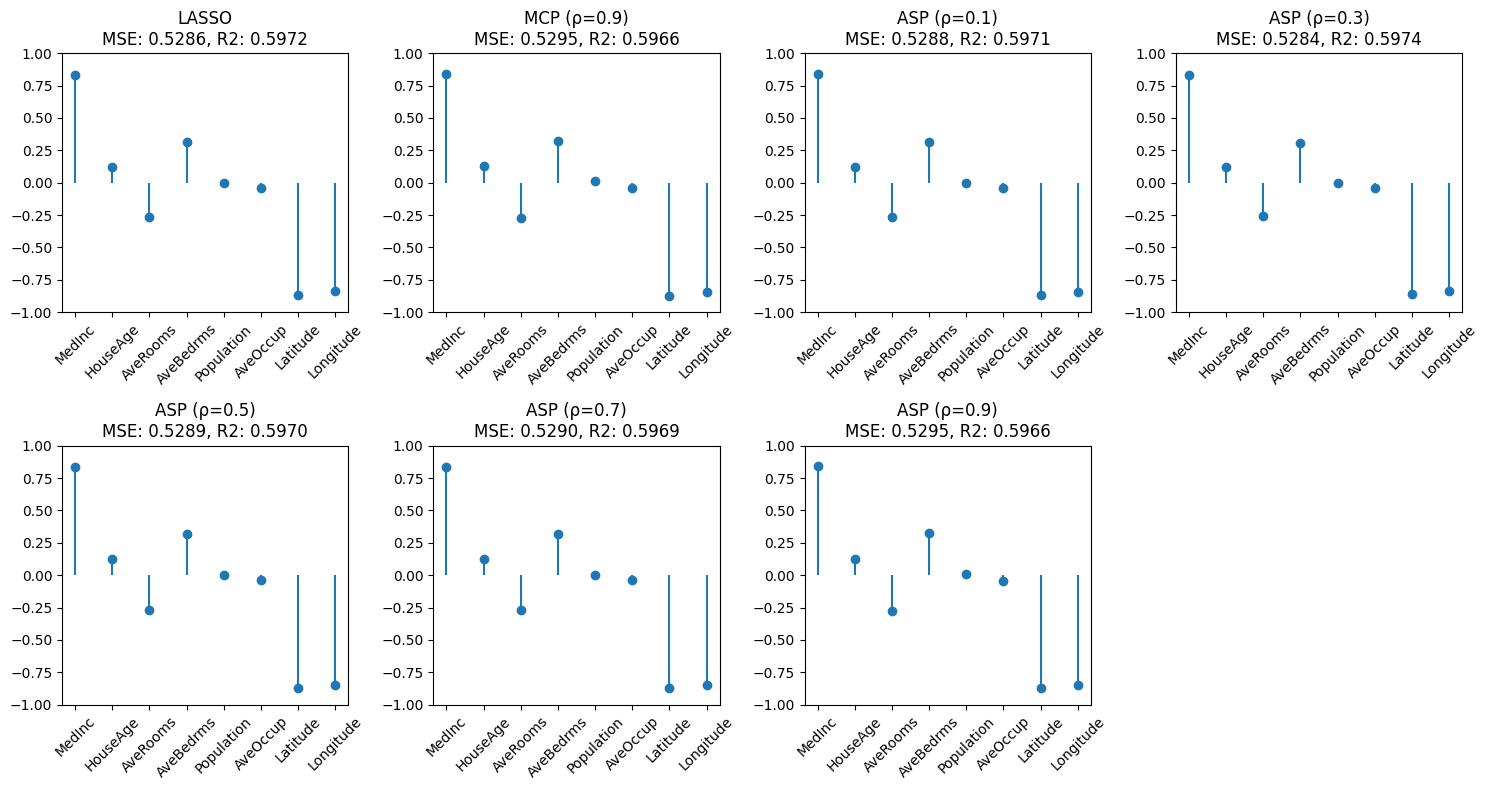

In [17]:
# Run the ML models with model evaluations
RealDataModelling()